# Skipception-30
Skipception 30 is a convolutional neural network constructed to classify 64x64px images across 30 different categories.

## Motivation
The primary goal of this project is to build a convolutional neural network archetcture that leverages skip connections as described by He et al. (2015) in the paper "[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)" and inception blocks as detailed by Szegedy et al. (2014) in "[Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842)."

Skip (shortcut) connections propigate information (identity) from one point in a convolutional neural network to a later point at which time it is added to the present state of the data. That is, the output of one layer is passed to layers deeper in the network through matrix addition. 

These skip connections offer an alternative route for our gradients with backpropagation aiding in the convergence of deep networks. This is one way to address the vanishing gradient problem. Additionally, skip connections allow for information captured eariler in the network to propagate forward into later parts of the network. He et al. (2015) further notes that "Identity shortcut connections add neither extra parameter nor computational complexity." 


Inception blocks were inspired by the need to address computational and memory inefficienicies of growing deep convolutional neural networks. XXXXXX


## Dataset Information

The dataset used for Skipception-30 is a modified version of [Tiny ImageNet](https://paperswithcode.com/dataset/tiny-imagenet). It contains 15,000 3x64x64 images for training, seperated into 30 classes with 500 images per class. An additional 1,500 images, 50 per class, are reserved as a test set. The modifications made for this project include removal of 170 classes and slight directory adjustments.

[Download Tiny-ImageNet-30](https://github.com/jahjinx/ML_skipception/tree/main/datasets)

## Imports

In [21]:
import os
import csv
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, Subset, DataLoader

from sklearn.model_selection import train_test_split

## Check & Define Device


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


## Load Data

In [3]:
# skip if local
from google.colab import drive 
drive.mount('/content/drive')

# change directory for local support in subesquent cells
%cd //content/drive/MyDrive/DS_projects/LD_copsForPortfolio/ML_skipception

Mounted at /content/drive
/content/drive/MyDrive/DS_projects/LD_copsForPortfolio/ML_skipception


In [4]:
# unzip dataset
!unzip "datasets/tiny-imagenet-30.zip" -d "/content/tiny-imagenet-30" &> /dev/null

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root="/content/tiny-imagenet-30/train_set", 
                      transform=transform)

print(dataset)

Dataset ImageFolder
    Number of datapoints: 15000
    Root location: /content/tiny-imagenet-30/train_set
    StandardTransform
Transform: Compose(
               ToTensor()
               ColorJitter(brightness=[0.8, 1.2], contrast=None, saturation=[0.8, 1.2], hue=[-0.2, 0.2])
               RandomAffine(degrees=[-10.0, 10.0], translate=(0.1, 0.1), scale=(0.9, 1.1))
               RandomHorizontalFlip(p=0.5)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [6]:
print(dataset.class_to_idx)

## the following saves the class to index mapping for use in other notebooks
## it only really needs to be run once

# class_to_idx = open("/content/drive/MyDrive/DS_projects/LD_copsForPortfolio/ML_skipception/class_to_idx-tiny-imagenet-30.pkl", "wb")

# pickle.dump(dataset.class_to_idx, class_to_idx)

# class_to_idx.close()

{'n01443537': 0, 'n01855672': 1, 'n01917289': 2, 'n02206856': 3, 'n02480495': 4, 'n02486410': 5, 'n02793495': 6, 'n02823428': 7, 'n02883205': 8, 'n02909870': 9, 'n02988304': 10, 'n03179701': 11, 'n03393912': 12, 'n03544143': 13, 'n03584254': 14, 'n03617480': 15, 'n03837869': 16, 'n03937543': 17, 'n04070727': 18, 'n04146614': 19, 'n04259630': 20, 'n04285008': 21, 'n04356056': 22, 'n04376876': 23, 'n04507155': 24, 'n04562935': 25, 'n07614500': 26, 'n07734744': 27, 'n07873807': 28, 'n12267677': 29}


In [7]:
batch = 64

# define indicies so that we can stratify our splits
train_indices, val_indices, _, _ = train_test_split(
    range(len(dataset)),
    dataset.targets,
    stratify=dataset.targets,
    test_size=0.2,
    random_state=0
)

# create subset with indices
train_split = Subset(dataset, train_indices)
val_split = Subset(dataset, val_indices)

# create batch loaders
train_batches = DataLoader(train_split, 
                           batch_size=batch, 
                           shuffle=True)

val_batches = DataLoader(val_split, 
                          batch_size=batch, 
                          shuffle=False)
# Report split sizes
print('Training batch has {} instances'.format(len(train_batches)))
print('Validation batch has {} instances'.format(len(val_batches)))

Training batch has 188 instances
Validation batch has 47 instances


## View Data

In [8]:
# link class names to mapped index for viewing
class_names = {} 

# open txt file and read lines
mapping = open('/content/tiny-imagenet-30/words.txt', 'r')
lines = mapping.readlines()

# split lines and save to respective dicts
# mapping id/name to index as prediction outputs will be in 0-n format
for i, line in enumerate(lines):
  class_names[line.split('\t')[0]] = line.split('\t')[1]

class_names = {k:v.strip() for (k, v) in class_names.items()}

In [9]:
class_name_to_idx = {dataset.class_to_idx[k]:v for (k, v) in class_names.items()}
print(class_name_to_idx)

{0: 'goldfish, Carassius auratus', 1: 'goose', 2: 'brain coral', 3: 'bee', 4: 'orangutan, orang, orangutang, Pongo pygmaeus', 5: 'baboon', 6: 'barn', 7: 'beer bottle', 8: 'bow tie, bow-tie, bowtie', 9: 'bucket, pail', 10: 'CD player', 11: 'desk', 12: 'freight car', 13: 'hourglass', 14: 'iPod', 15: 'kimono', 16: 'obelisk', 17: 'pill bottle', 18: 'refrigerator, icebox', 19: 'school bus', 20: 'sombrero', 21: 'sports car, sport car', 22: 'sunglasses, dark glasses, shades', 23: 'syringe', 24: 'umbrella', 25: 'water tower', 26: 'ice cream, icecream', 27: 'mushroom', 28: 'pizza, pizza pie', 29: 'acorn'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26: ice cream, icecream
13: hourglass
15: kimono
20: sombrero
18: refrigerator, icebox
29: acorn


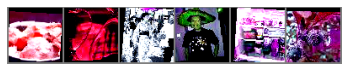

In [10]:
# Helper function for inline image display
def matplotlib_imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_batches)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images[0:6])
matplotlib_imshow(img_grid)
for j in range(6):
  print(f"{int(labels[j])}: {class_name_to_idx[int(labels[j])]}")

## Define Network

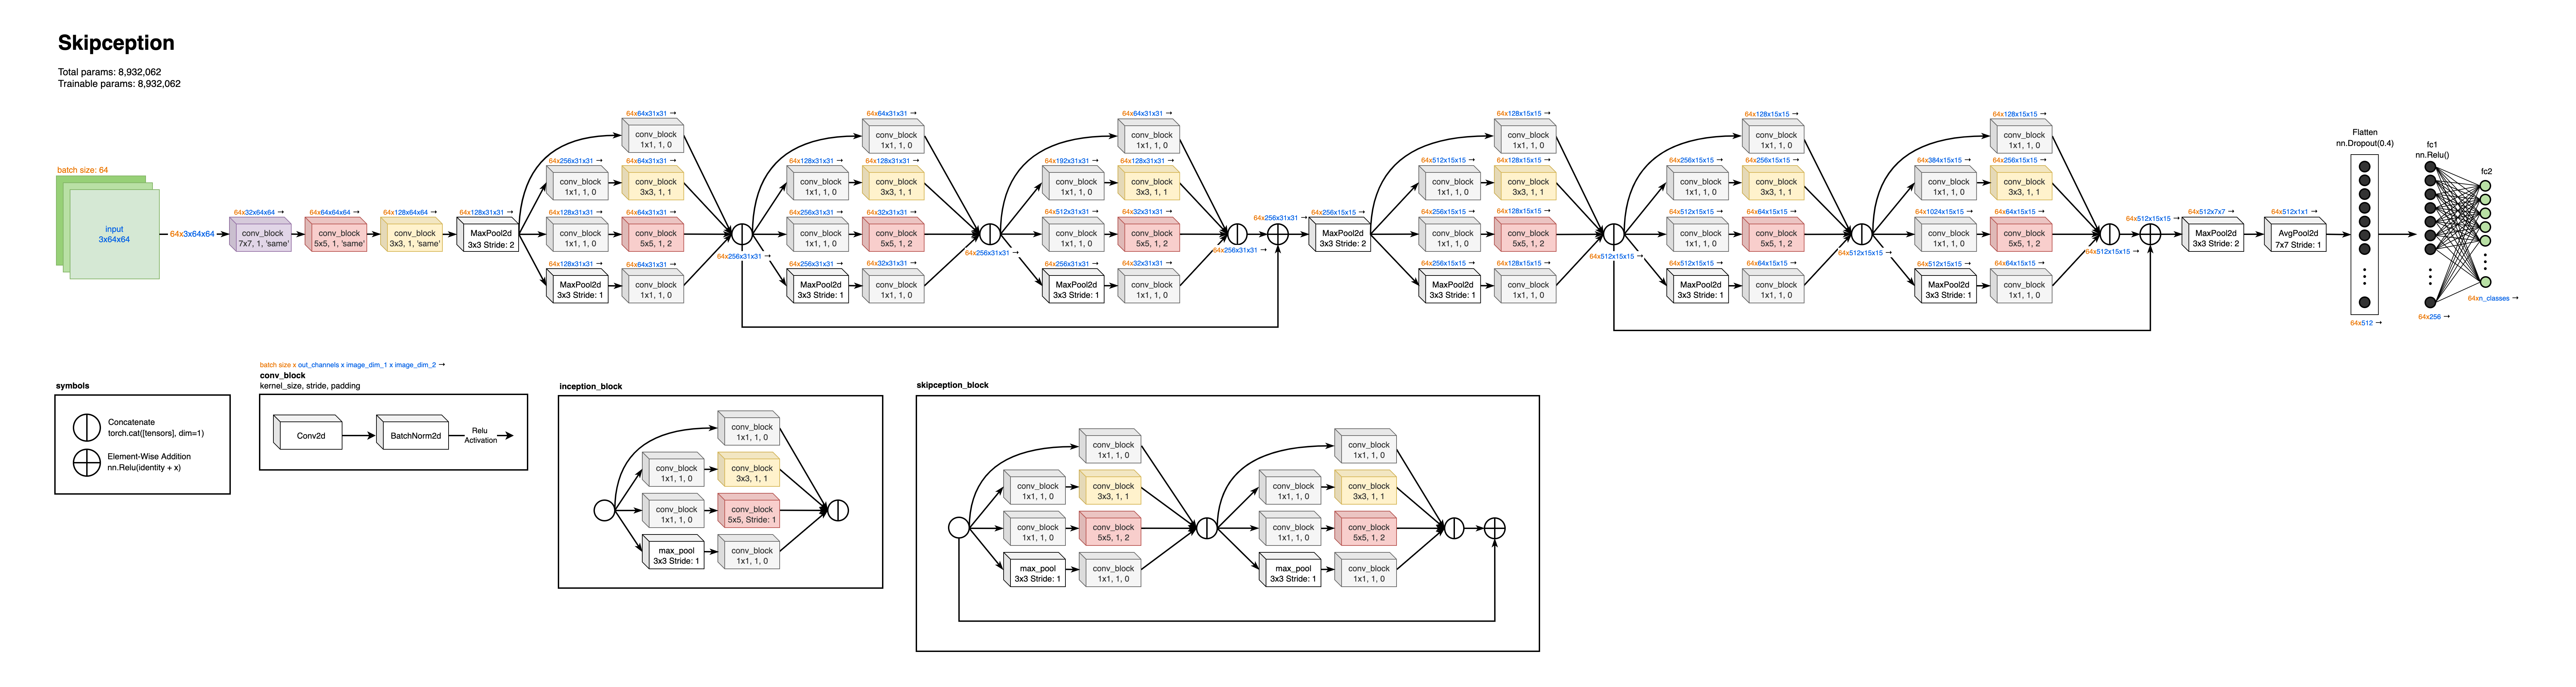

[Enlarge Schematic](https://drive.google.com/file/d/1PLJSG-_9nUG2175qZ08YNMEO3dqNj4Pi/view?usp=sharing)

In [11]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(self.batchnorm(x))
        return x

class inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1_pool):
        super().__init__()
        
        self.branch_1 = conv_block(in_channels, out_1x1, kernel_size=1)

        self.branch_2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=1),
            conv_block(red_3x3, out_3x3, kernel_size=3, padding=1)
        )

        self.branch_3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1),
            conv_block(red_5x5, out_5x5, kernel_size=5, padding=2)
        )

        self.branch_4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1_pool, kernel_size=1)
        )

    def forward(self, x):
        return torch.cat([self.branch_1(x), self.branch_2(x), self.branch_3(x), self.branch_4(x)], 1)

class skipception_block(nn.Module):
    def __init__(self, in_channels, red_3x3, red_5x5):
        super().__init__()

        self.relu = nn.ReLU()

        inception: int(in_channels, red_3x3, red_5x5)
        out_1x1 = int(in_channels/4)
        out_3x3 = int(in_channels/2)
        out_5x5 = int(in_channels/8)
        out_1x1_pool = int(in_channels/8)

        red_3x3_2 = int(red_3x3*1.5)
        red_5x5_2 = int(red_5x5*2)

        self.inception1 = inception_block(in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1_pool)
        self.inception2 = inception_block(in_channels, out_1x1, red_3x3_2, out_3x3, red_5x5_2, out_5x5, out_1x1_pool)

    def forward(self, x):
        identity = x

        x = self.inception1(x)
        x = self.inception2(x)

        out = identity + x

        out = self.relu(out)

        return out

class Classifier_Skipception(nn.Module):
    def __init__(self, num_classes=30):
        super().__init__( )
        
        self.relu = nn.ReLU()

        self.conv1 = conv_block(in_channels=3, out_channels=32, kernel_size=7, padding='same')
        self.conv2 = conv_block(in_channels=32, out_channels=64, kernel_size=5, padding='same')         
        self.conv3 = conv_block(in_channels=64, out_channels=128, kernel_size=3, padding='same')         
        
        # inception skip, input size from previous layer,
        # output from inception skip must eqal in_channels
        # inception: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1_pool
        self.inception1 = inception_block(128, 64, 256, 64, 128, 64, 64)
        self.skipception1 = skipception_block(256, 128, 256)

        self.inception2 = inception_block(256, 128, 512, 128, 256, 128, 128)
        self.skipception2 = skipception_block(512, 256, 512)


        self.max_pool = nn.MaxPool2d(3, 2)
        self.avg_pool = nn.AvgPool2d(7, 1)

        self.dropout = nn.Dropout(0.4)

        self.fc1 = nn.Linear(512*1*1, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.max_pool(x)

        x = self.inception1(x)
        x = self.skipception1(x)
        x = self.max_pool(x)

        x = self.inception2(x)
        x = self.skipception2(x) 
        x = self.max_pool(x)

        x = self.avg_pool(x)

        x = x.reshape(x.size(0), -1) # flatten the input
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Instantiate Model

In [12]:
model = Classifier_Skipception()

In [13]:
model.to(device)

Classifier_Skipception(
  (relu): ReLU()
  (conv1): conv_block(
    (relu): ReLU()
    (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): conv_block(
    (relu): ReLU()
    (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): conv_block(
    (relu): ReLU()
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (inception1): inception_block(
    (branch_1): conv_block(
      (relu): ReLU()
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch_2): Sequential(
      (0): conv_block

## Train Model

In [14]:
def validate(model, val_dl, loss_fn):
  model.eval()
  val_loss = 0.0
  num_val_correct = 0
  num_val_examples = 0

  with torch.no_grad():
    for batch in val_dl:
      x    = batch[0].to(device)
      y    = batch[1].to(device)
      yhat = model(x)
      loss = loss_fn(yhat, y)

      val_loss         += loss.data.item() * x.size(0)
      num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
      num_val_examples += y.shape[0]

  val_acc  = num_val_correct / num_val_examples
  val_loss = val_loss / len(val_dl.dataset)

  return val_acc, val_loss

def save_model(epoch, save_dir=None, save_filename=None, save_freq=20):
  if save_dir != None and ((epoch)%save_freq == 0):
    
    results_path = os.path.join(save_dir, f'{save_filename}_ep{epoch}.pt')

    state = {'epoch': epoch, 
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()
              }

    try:
      torch.save(state, results_path)
      print(f'Model @ epoch {epoch} saved to {results_path}')
      
    except Exception:
      print(f'Model @ epoch {epoch} not saved')
      pass

def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=100, device='cpu', 
          save_dir=None, save_filename=None, save_freq=20):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s, save_dir=%s%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device, save_dir, save_filename))

    history = {} # Collects per-epoch loss and acc
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []

    start_time_sec = time.time()

    for epoch in range(1, epochs+1):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        for batch in train_dl:

            optimizer.zero_grad()

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss         += loss.data.item() * x.size(0)
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        val_acc, val_loss = validate(model, val_dl, loss_fn)

        if epoch == 1 or epoch % 1 == 0:
          print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
                (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)
    
        # ----------- SAVE -----------
        save_model(epoch, save_dir, save_filename, save_freq)

    # END OF TRAINING LOOP

    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history

In [15]:
# define Loss Function and Optimizer
epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
save_dir = 'saved_models/'
save_filename = 'skipception_TI-30'
save_freq = 20

# train
history = train(model, optimizer, loss_fn, train_batches, val_batches, epochs, 
                device, save_dir, save_filename, save_freq)

train() called: model=Classifier_Skipception, opt=SGD(lr=0.001000), epochs=100, device=cuda:0, save_dir=saved_models/skipception_TI-30

Epoch   1/100, train loss:  3.26, train acc:  0.09, val loss:  3.00, val acc:  0.15
Epoch   2/100, train loss:  2.91, train acc:  0.17, val loss:  2.68, val acc:  0.23
Epoch   3/100, train loss:  2.66, train acc:  0.23, val loss:  2.60, val acc:  0.25
Epoch   4/100, train loss:  2.47, train acc:  0.28, val loss:  2.49, val acc:  0.29
Epoch   5/100, train loss:  2.34, train acc:  0.32, val loss:  2.32, val acc:  0.32
Epoch   6/100, train loss:  2.24, train acc:  0.34, val loss:  2.20, val acc:  0.36
Epoch   7/100, train loss:  2.16, train acc:  0.36, val loss:  2.14, val acc:  0.38
Epoch   8/100, train loss:  2.08, train acc:  0.39, val loss:  2.16, val acc:  0.38
Epoch   9/100, train loss:  2.02, train acc:  0.41, val loss:  1.98, val acc:  0.43
Epoch  10/100, train loss:  1.95, train acc:  0.43, val loss:  1.97, val acc:  0.44
Epoch  11/100, train los

In [16]:
# save history
saved_history = open("saved_models/history_skipception_TI-30.pkl", "wb")
pickle.dump(history, saved_history)
saved_history.close()

# Metrics

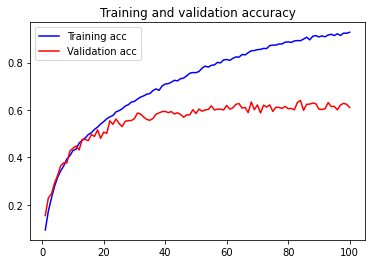

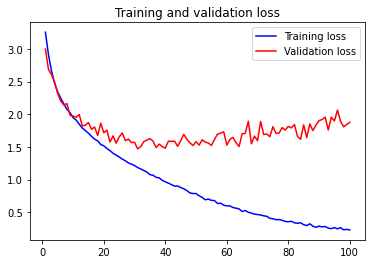

In [17]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Test on Test Data

## Load Test Data

In [15]:
# define dataset clas to properly load test set with labels
class ImageMap(Dataset):
  def __init__(self, root_dir, label_txt_file, class_to_idx, transform=None):
      self.root_dir = root_dir # location of images folder
      self.label_txt_file = label_txt_file # filename for true label/image map
      self.class_to_idx = class_to_idx

      # open and read label text file
      self.label_open = open(f"{self.root_dir}/{label_txt_file}", 'r')
      self.lines = self.label_open.readlines()
      # split lines, get image file name
      self.image_filenames = [line.split('\t')[0] for line in self.lines]
      # split lines, get true image labels
      self.image_labels = [line.split('\t')[1] for line in self.lines]

      # set transform
      self.transform = transform

  def __len__(self):
          return len(self.image_labels)

  def __getitem__(self, idx):
          # get one label by index
          label_name = self.image_labels[idx]

          # us this to map class to index as from training
          label_mapping = torch.as_tensor(self.class_to_idx[label_name])

          # define one image directory and open as PIL image
          img_dir = f"{self.root_dir}/images/{self.image_filenames[idx]}"
          with open(img_dir, 'rb') as f:
            img = Image.open(f)
            img = img.convert('RGB')

          # transform if transforms defined
          if self.transform is not None:
            img = self.transform(img)

          return img, label_mapping

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageMap('/content/tiny-imagenet-30/test_set', 'test_labels.txt', 
                        dataset.class_to_idx,
                        transform=transform)

In [18]:
batch = 1

test_batches = DataLoader(test_dataset, 
                          batch_size=batch, 
                          shuffle=False)

In [19]:
len(test_batches)

1500

## View Test Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


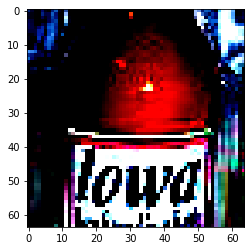

In [22]:
plt.imshow(test_dataset[1][0].permute(1, 2, 0))

## Load Model @ Desired Epoch

In [36]:
# ----------- LOAD -----------
results_path = 'saved_models/skipception_TI-30_ep60.pt'

model = Classifier_Skipception()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

checkpoint = torch.load(results_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [37]:
model.to(device)

Classifier_Skipception(
  (relu): ReLU()
  (conv1): conv_block(
    (relu): ReLU()
    (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): conv_block(
    (relu): ReLU()
    (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): conv_block(
    (relu): ReLU()
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (inception1): inception_block(
    (branch_1): conv_block(
      (relu): ReLU()
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch_2): Sequential(
      (0): conv_block

## Generate Predictions & Evaluate

In [38]:
 # --- EVALUATE ON VALIDATION SET -------------------------------------
model.eval()
num_test_correct  = 0
num_test_examples = 0
preds = []
trues = []

with torch.no_grad():
  for batch in test_batches:
      # print(x.shape)
      x    = batch[0].to(device)
      y    = batch[1].to(device)
      yhat = model(x)

      preds.append(torch.max(yhat, 1)[1].item())
      trues.append(y[0].item())

      num_test_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
      num_test_examples += y.shape[0]

  test_acc  = num_test_correct / num_test_examples

print(preds)
print(trues)
print(test_acc)

[17, 7, 19, 10, 16, 26, 6, 17, 14, 12, 17, 5, 29, 6, 25, 0, 29, 13, 19, 3, 17, 14, 13, 10, 7, 27, 25, 25, 2, 16, 11, 12, 20, 26, 20, 25, 12, 11, 2, 21, 17, 15, 12, 4, 10, 10, 20, 22, 6, 28, 13, 10, 29, 11, 27, 16, 13, 4, 11, 10, 11, 9, 28, 2, 19, 2, 13, 19, 25, 17, 17, 10, 10, 13, 4, 5, 1, 17, 4, 26, 24, 11, 13, 29, 10, 14, 28, 2, 9, 10, 10, 9, 5, 9, 1, 5, 29, 13, 18, 6, 20, 2, 21, 29, 29, 5, 14, 9, 11, 11, 11, 0, 23, 2, 9, 27, 6, 21, 3, 0, 0, 25, 10, 15, 16, 10, 14, 29, 18, 27, 28, 26, 4, 16, 17, 15, 12, 27, 27, 15, 5, 5, 14, 10, 18, 5, 18, 10, 17, 3, 0, 25, 19, 13, 14, 19, 9, 28, 8, 5, 27, 4, 9, 11, 10, 19, 25, 1, 16, 2, 4, 3, 1, 8, 20, 1, 14, 21, 4, 19, 5, 6, 15, 17, 13, 28, 17, 8, 15, 11, 17, 8, 19, 11, 9, 2, 15, 17, 24, 3, 0, 7, 28, 5, 0, 2, 13, 17, 18, 0, 16, 18, 2, 17, 18, 13, 8, 26, 6, 20, 2, 29, 14, 10, 29, 20, 17, 29, 26, 13, 5, 10, 10, 3, 17, 12, 14, 28, 28, 21, 10, 14, 14, 6, 6, 8, 10, 0, 3, 21, 21, 18, 5, 20, 5, 12, 28, 12, 17, 21, 10, 8, 12, 0, 3, 9, 18, 13, 9, 29, 2, 25,

# Network Overview

In [26]:
from torchsummary import summary
summary(model, input_size=(3, 64, 64), batch_size=64, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 32, 64, 64]           4,736
       BatchNorm2d-2           [64, 32, 64, 64]              64
              ReLU-3           [64, 32, 64, 64]               0
        conv_block-4           [64, 32, 64, 64]               0
            Conv2d-5           [64, 64, 64, 64]          51,264
       BatchNorm2d-6           [64, 64, 64, 64]             128
              ReLU-7           [64, 64, 64, 64]               0
        conv_block-8           [64, 64, 64, 64]               0
            Conv2d-9          [64, 128, 64, 64]          73,856
      BatchNorm2d-10          [64, 128, 64, 64]             256
             ReLU-11          [64, 128, 64, 64]               0
       conv_block-12          [64, 128, 64, 64]               0
        MaxPool2d-13          [64, 128, 31, 31]               0
           Conv2d-14           [64, 64,